# Introduction
This implements the iterative classification algorithm as described in slide 37 of http://web.stanford.edu/class/cs224w/slides/05-message.pdf  
It classifies a node based on its features as well as labels of neighbours

## Definitions
$v$: Node  
$Y_v$: Labels of node $v$  
$f_v$: feature vector of node $v$  
$z_v$: summary of labels of $v$'s neighbours (a vector)  
$\phi_1(f_v)$: predict node label based on node feature vector $f_v$  
$\phi_2(f_v, z_v)$: predict label based on node feature vector $f_v$ of labels of $v$'s neighbours

## Phase 1: Train a Classifier based on node attributes only
The classifier can be linear classifier, neural network classifier etc. This is trained on the training set to predict the labels for each node.

$\phi_1(f_v)$ : to predict $Y_v$ based on $f_v$  
$\phi_2(f_v, z_v)$ to predict $Y_v$ based on $f_v$ and summary $z_v$ of labels of $v$'s neighbours  
For vector $z_v$ of neighbourhood labels, let

- $I$ = incoming neighbour label info vector  
  $I_0$ = 1 if at least one of the incoming node is labelled 0.  
  $I_1$ = 1 if at least one of the incoming node is labelled 1.
- $O$ = outgoing neighbour label info vector  
  $O_0$ = 1 if at least one of the outgoing node is labelled 1.  
  $O_1$ = 1 if at least one of the outgoing node is labelled 1.

## Phase 2: Iterate till Convergence

On the test set, set the labels based on the classifier in Phase 1,

## Step 1: Train Classifier

On a different training set, train two classifiers:

- node attribute vector only: $\phi_1$
- node attribute and link vectors: $\phi_2$

## Step 2: Apply Classifier to test set

On test set, use trained node feature vector classifier $\phi_1$ to set $Y_v$

## Step 3.1: Update relational vectors z

Update $z_v$ for all nodes on test set

## 3.2: Update Label

Reclassify all nodes with $\phi_2$

## Iterate

Continue until convergence

- update $z_v$
- update $Y_v = \phi_2(f_v, z_v)$

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
while Path.cwd().name != 'bayesian_beats_cheats':
    os.chdir(Path.cwd().parent)

import pandas as pd
import networkx as nx
from iterative_yyy.collective.constants import get_summary_zv
from iterative_yyy.collective.Iterative import IterativeClassification

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix

from iterative_yyy import parse

from src import preprocess
import matplotlib.pyplot as plt
import numpy as np
from src.visualization import make_confusion_matrix


In [2]:
df_node = pd.read_csv('data/imputed_unified_node_data.csv', keep_default_na=False)
df_edge = pd.read_csv('data/max_edge_weights.csv')

# combine train and val together to train
X_train, X_val, X_test, y_train, y_val, y_test = preprocess.stratified_train_val_test_split(df_node)

for x_df in [X_train, X_val, X_test]:
    x_df.drop(columns=['confessed_assignments'], inplace=True)
for y_df in [y_train, y_val, y_test]:
    y_df.update((y_df>0).astype(int))
    y_df.rename("label", inplace=True)

# check class distribution
print(y_train.value_counts())

# downsample
TRAIN = pd.concat([X_train, y_train], axis='columns')
VAL   = pd.concat([X_val,   y_val],   axis='columns')
X_downsample = preprocess.downsample(TRAIN, 'label', random_state=0)
X_downsample_train = X_downsample.iloc[:, :-1]
y_downsample_train = X_downsample['label']
# check downsampled class distribution
print(y_downsample_train.value_counts())


X_combine = pd.concat([X_train, X_val], axis='index')
y_combine = pd.concat([y_train, y_val], axis='index')
COMBINE = pd.concat([X_combine, y_combine], axis='columns')

0    614
1    102
Name: label, dtype: int64
1    102
0    102
Name: label, dtype: int64


In [3]:
%%time
print("Training model on imputed data")

model = LogisticRegression(class_weight='balanced', max_iter=10000)
# model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample')
# model = GaussianNB()
# model = SVC(gamma=2, C=1, class_weight='balanced')
# model = SVC(kernel="linear", C=0.025, class_weight='balanced')
# model = AdaBoostClassifier()

model1 = model
model1.fit(X_combine.drop(columns=['name']), y_combine)


# model1 = model
# model1.fit(X_train.drop(columns=['name']), y_train)
# y_pred = model1.predict(X_val.drop(columns=['name']))

# cf = confusion_matrix(y_val, y_pred)
# make_confusion_matrix(cf)

# plt.show()

# ### The model above using original data performs better with F1 score ####
# print("Training model on downsampled imputed data")

# model1 = model
# model1.fit(X_downsample_train.drop(columns=['name']), y_downsample_train)
# y_pred = model1.predict(X_val.drop(columns=['name']))

# cf = confusion_matrix(y_val, y_pred)
# make_confusion_matrix(cf)

# plt.show()

Training model on imputed data
Wall time: 670 ms


LogisticRegression(class_weight='balanced', max_iter=10000)

### model 1 only node features
1. train model use node features to predict test labels using test data

### model 2 with edges and Ln features
2. create network graph on train data (using node features + edge features + l0, l1, ... features + true labels)
3. train model 2 to use: (node features + edge features + l0, l1, ... features) -> labels

4. Use model 2 to iteratively predict labels on test data network
maxiter/no change

In [4]:
%%time

# add nodes to graph
network_graph_combine = parse.create_nx_graph_nodes(COMBINE)
# add edges to graph
network_graph_combine = parse.add_nx_graph_edges(network_graph_combine, df_edge)
# compute L1_max, L0_max, L1_mean, L0_mean
network_graph_combine = get_summary_zv(network_graph_combine)
# convert to df
df_combine = pd.DataFrame.from_dict(network_graph_combine.nodes, orient='index')

# network_graph_train = parse.create_nx_graph_nodes(TRAIN)
# network_graph_train = parse.add_nx_graph_edges(network_graph_train, df_edge)
# network_graph_train = get_summary_zv(network_graph_train)
# df_train = pd.DataFrame.from_dict(network_graph_train.nodes, orient='index')

# network_graph_val = parse.create_nx_graph_nodes(VAL)
# network_graph_val = parse.add_nx_graph_edges(network_graph_val, df_edge)
# network_graph_val = get_summary_zv(network_graph_val)
# df_val = pd.DataFrame.from_dict(network_graph_val.nodes, orient='index')

# use predicted labels from model1
y_pred = model1.predict(X_test.drop(columns=['name']))
TEST = pd.concat([X_test, pd.Series(y_pred, index=X_test.index, name='label')], axis='columns')

network_graph_test = parse.create_nx_graph_nodes(TEST)
network_graph_test = parse.add_nx_graph_edges(network_graph_test, df_edge)
network_graph_test = get_summary_zv(network_graph_test)
df_test = pd.DataFrame.from_dict(network_graph_test.nodes, orient='index')

Wall time: 1.71 s


In [5]:
# X_train_with_link_features = df_train.drop(['label'], axis=1)
# y_train_with_link_features = df_train['label']

# df_downsample_train = preprocess.downsample(df_train, 'label', random_state=0)
# X_downsample_train_with_link_features = df_downsample_train.drop(['label'], axis=1)
# y_downsample_train_with_link_features = df_downsample_train['label']

# X_val_with_link_features = df_val.drop(['label'], axis=1)
# y_val_with_link_features = df_val['label']

# print("original train", X_train_with_link_features.shape)
# print("downsampled train", X_downsample_train_with_link_features.shape)
# print("validation", X_val_with_link_features.shape)

In [6]:
# print("Training model2")
# model2 = LogisticRegression(class_weight='balanced')
# model2.fit(X_train_with_link_features, y_train_with_link_features)
# y_pred2 = model2.predict(X_val_with_link_features)

# cf = confusion_matrix(y_val_with_link_features, y_pred2)
# make_confusion_matrix(cf)

# plt.show()

# ### The model above using original data performs better with F1 score ####
# print("Training model on downsampled imputed data")

# model2 = LogisticRegression(class_weight='balanced')
# model2.fit(X_downsample_train_with_link_features, y_downsample_train_with_link_features)
# y_pred2 = model2.predict(X_val_with_link_features)

# cf = confusion_matrix(y_val_with_link_features, y_pred2)
# make_confusion_matrix(cf)

# plt.show()

In [7]:
%%time
model2 = LogisticRegression(class_weight='balanced', max_iter=10000)
model2.fit(df_combine.drop(['label'], axis=1), df_combine['label'])

Wall time: 920 ms


LogisticRegression(class_weight='balanced', max_iter=10000)

Before iterative


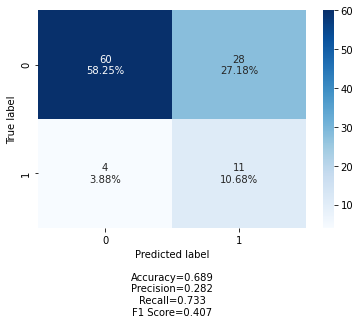

<timed exec>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
converged in 2 iterations
After iterative


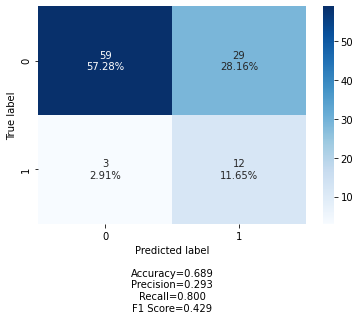

Wall time: 732 ms


In [8]:
%%time

max_iter = 1000
num_iter = 0

print("Before iterative")
before_labels = df_test['label'].copy()
cf = confusion_matrix(y_test, df_test['label'])
make_confusion_matrix(cf)

plt.show()

old_labels = -np.ones(df_test['label'].shape, dtype=np.int)
while np.sum(df_test['label'] != old_labels) > 0 and num_iter < max_iter:
    num_iter += 1
    old_labels = df_test['label'].values.copy()

    df_test['label'] = model2.predict(df_test.drop(['label'], axis=1))
    for name, label in df_test['label'].iteritems():
        network_graph_test.nodes[name]['label'] = label
    network_graph_test = get_summary_zv(network_graph_test) # update L0, L1 features
    df_test = pd.DataFrame.from_dict(network_graph_test.nodes, orient='index')

if num_iter == max_iter:
    print(f"did not converge in {max_iter}")
else:
    print(f"converged in {num_iter} iterations")

print("After iterative")
after_labels = df_test['label'].copy()
cf = confusion_matrix(y_test, df_test['label'])
make_confusion_matrix(cf)

plt.show()

In [9]:
df_final = df_test.copy()
predictions = model2.predict_proba(df_final.drop(['label'], axis=1))[:, 1]
df_final['true_labels'] = y_test.values
df_final['pred_label'] = predictions
df_final.sort_values('pred_label', ascending=False, inplace=True)
df_final.head(20)

,year_of_study,participation,pe_percent,finals_percent,midterms_percent,afast,level_min_max,exp_min_max,t01_exp,t02_exp,...,major_School of Design & Environment,major_Statistics,major_Yong Loo Lin School (Medicine),label,L1_max,L0_max,L1_mean,L0_mean,true_labels,pred_label
dana_gordon,1,3.50,0.333333,0.140000,0.394500,0,0.560000,0.427891,260,260,...,1,0,0,1,0.000000,0.000000,0.000000,0.000000,0,0.856746
brian_elliott,1,3.05,0.474167,0.342000,0.225000,0,0.777778,0.641775,0,250,...,0,0,0,1,0.033390,0.014528,0.024728,0.010828,1,0.813489
kaitlin_gregory,1,3.25,0.650000,0.477000,0.516667,0,0.666667,0.489724,275,275,...,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0,0.737599
ricky_torres,1,3.35,0.573333,0.331000,0.683333,0,0.861111,0.755882,250,275,...,0,0,0,1,0.000000,0.000000,0.000000,0.000000,1,0.724608
michael_adams,1,3.00,0.400000,0.260000,0.406333,0,0.800000,0.711217,220,240,...,0,0,0,1,0.000000,0.022846,0.000000,0.022846,0,0.716182
jeff_hines,1,3.75,0.501667,0.390667,0.383333,0,0.833333,0.712674,275,275,...,0,0,0,1,0.000000,0.009786,0.000000,0.009786,1,0.709220
daniel_morris,2,3.00,0.050000,0.173333,0.160000,0,0.800000,0.741461,200,250,...,0,0,0,1,0.014178,0.019965,0.014178,0.016184,0,0.687619
tyrone_mckee,3,2.50,0.133333,0.170000,0.413333,0,0.760000,0.674317,260,260,...,0,0,0,1,0.000000,0.000000,0.000000,0.000000,1,0.687090
felicia_davidson,1,3.60,0.636667,0.420000,0.541667,0,0.777778,0.646398,275,225,...,0,0,0,1,0.008835,0.000000,0.008835,0.000000,0,0.681903
amy_miller,1,4.00,0.675000,0.633333,0.640000,0,1.000000,0.990325,250,225,...,0,0,0,1,0.033390,0.014334,0.024621,0.014334,0,0.675099
